In [ ]:
import seaborn as sns
import numpy as np
import pandas as pd
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV

#El modelo a usar:

from sklearn.neighbors import KNeighborsClassifier

#Importamos el dataset
Debe estar ya limpio y con todas las variables numericas (ya con one hot encoding o label encoding)

In [ ]:
#Importamos el dataset
df=pd.read_csv('/content/ObesidadLimpia.csv')
df.head()

,Age,Height,Weight,FCVC,NCP,CAEC,CH2O,FAF,TUE,CALC,NObeyesdad,Gender_Male,family_history_with_overweight_yes,SMOKE_yes,SCC_yes,FAVC_yes,MTRANS_Bike,MTRANS_Motorbike,MTRANS_Public_Transportation,MTRANS_Walking
0,0.148936,-0.875432,0.198323,0.5,0.666667,0.333333,0.5,0.000000,0.5,0.000000,Normal_Weight,0,1,0,0,0,0,0,1,0
1,0.148936,-1.950036,0.134859,1.0,0.666667,0.333333,1.0,1.000000,0.0,0.333333,Normal_Weight,0,1,1,1,0,0,0,1,0
2,0.191489,1.058855,0.301450,0.5,0.666667,0.333333,0.5,0.666667,0.5,0.666667,Normal_Weight,1,1,0,0,0,0,0,1,0
3,0.276596,1.058855,0.380779,1.0,0.666667,0.333333,0.5,0.666667,0.0,0.666667,Overweight_Level_I,1,0,0,0,0,0,0,0,1
4,0.170213,0.843934,0.402991,0.5,0.000000,0.333333,0.5,0.000000,0.0,0.333333,Overweight_Level_II,1,0,0,0,0,0,0,1,0


In [ ]:
#Separamos el target del resto de variables
X=df.drop(['NObeyesdad'],axis=1)
y=df['NObeyesdad']

#Algoritmo genetico

In [ ]:
#Este vector de nombres de variables sera el espacio sobre el que trabajaremos para optimizar
#El fin es seleccionar las variables que nos den la mejor accuracy (o puede ser otra metrica)
Variables=X.columns
Variables

Index(['Age', 'Height', 'Weight', 'FCVC', 'NCP', 'CAEC', 'CH2O', 'FAF', 'TUE',
       'CALC', 'Gender_Male', 'family_history_with_overweight_yes',
       'SMOKE_yes', 'SCC_yes', 'FAVC_yes', 'MTRANS_Bike', 'MTRANS_Motorbike',
       'MTRANS_Public_Transportation', 'MTRANS_Walking'],
      dtype='object')

In [ ]:
#El primer paso es crear vectores iniciales aleatorios, se dice que el numero indicado  es 5*D vectores iniciales , D es la cantidad de variables
NumVectores=5*X.shape[1]
VectoresIniciales=np.random.randint(0,2,size=(NumVectores,X.shape[1]))

In [ ]:
#ESTOS PARAMETROS SON LOS DEL ALGORITMO , LOS PODEMOS MODIFICAR, ESTOS LOS PUSE PARA PROBAR PERO LOS PUEDEN VARIAR PARA DIFERENTES RESULTADOS
ProbCruce=0.6
ProbMut=0.1
Generaciones=10

In [ ]:
#ESTE DICCIONARIO ES CON EL QUE SE VA A HACER GRIDSEARCH, SE PASA EL PARAMETRO Y QUE SE QUIERE PROBAR

"""
Esta adaptacion incluye un posible uso de gridsearch y validacion cruzada. En este caso se puede poner un rango
de K y despues de ver los resultados escoger uno y volver a aplicar el algoritmo en busqueda de mejores resultados
"""

#PARA EL KNN:

#Primero buscamos la mejor K de 1 a 20, encontramos que la mejor era K=6 y despues volvimos a ejecutar el algortimo
Dict_Parametros={'n_neighbors': [6]}#{'n_neighbors': list(range(1, 21))}

#METRICA DE EVALUACION A OPTIMIZAR: accuracy
scoring='accuracy'

#CUANTOS FOLDS PARA HACER LA VALIDACION CRUZADA USAR
cv=5

#EL TAMAÑO DE LA DIVISION EN EL TEST PRUEBA
test_size=0.2

#EL RANDOM STATE
random_state=42

## El algoritmo codificado

In [ ]:
from typing import Dict
#Esta es una funcion que en base a un vector binario me devuelve un vector de caracteristicas

def ObtenerCaracteristicas(Binario,caracteristicas):
    Caracteristicas=[]
    for i in range(len(Binario)):
        if Binario[i]==1:
            Caracteristicas.append(caracteristicas[i])
    return Caracteristicas

#En esta funcion hacemos la evaluacion del modelos, con gridsearch y validacion cruzada. Debe cambiarse dependiendo del metodo

def Evaluar(i,X,y,Parametros):

    Caracteristicas=ObtenerCaracteristicas(i,Variables)

    #Obtengo X con ellas
    X_train, X_test, y_train, y_test = train_test_split(X[Caracteristicas], y, test_size=test_size, random_state=random_state)

    # Crear el modelo KNN
    knn = KNeighborsClassifier()

    # Definir los posibles valores de K a explorar
    param_grid = Dict_Parametros#{'n_neighbors': list(range(1, 21))}  # Valores de K entre 1 y 20

    # Configurar la búsqueda en cuadrícula con validación cruzada de 5 pliegues
    grid_search = GridSearchCV(knn, param_grid, cv=cv, scoring=scoring)

    # Entrenar el modelo con búsqueda de hiperparámetros
    grid_search.fit(X_train, y_train)

    promedio_puntajes = np.mean(grid_search.cv_results_['mean_test_score'])

    return promedio_puntajes,grid_search.best_params_

  #Paso 3: Hacemos la seleccion de dos padres que despues se van a cruzar
def Seleccion(VectoresIniciales):
  #Como la generacion actual puede tener individuos repetidos nos quedamos solamente con los unicos
  variables_unicas, indices_unicos = np.unique(VectoresIniciales, axis=0, return_index=True)

  # Me quedo tambien con las metricas de esos individuos unicos, este array de metricas tiene las accuracy del individuo en su misma posicion
  metricas_filtradas = Metricas[indices_unicos]

  #Ahora hago la ruleta
  Total=np.sum(metricas_filtradas)
  Probabilidades=metricas_filtradas/Total
  Probabilidades=np.cumsum(Probabilidades)

  #Creamos un numero entre 0 y 1 aleatorio

  N=np.random.random()

  #Hacemos a los padres usando probabilidad
  Padre1=None
  Padre2=None
  for i in range(len(Probabilidades)):
      if N<Probabilidades[i]:
          Padre1=variables_unicas[i]
          break
  N=np.random.random()
  for i in range(len(Probabilidades)):
      if N<Probabilidades[i]:
          Padre2=variables_unicas[i]
          break
  return Padre1,Padre2


#Paso 4: Hacemos el cruce de los papás

def Cruce(padre1, padre2, ProbCruce):
    # Generamos un número aleatorio entre 0 y 1 para determinar si se debe hacer el cruce
    if np.random.random() < ProbCruce:
        # Si la probabilidad es menor que la tasa de cruce, realizamos el cruce
        punto_cruce = np.random.randint(1, len(padre1)-1)  # Elegimos un punto aleatorio para el cruce (Claramente no puede ser ni 0 ni el ultimo)

        # Generamos los hijos intercambiando las partes antes y después del punto de cruce
        hijo1 = np.concatenate((padre1[:punto_cruce], padre2[punto_cruce:]))
        hijo2 = np.concatenate((padre2[:punto_cruce], padre1[punto_cruce:]))
    else:
        # Si no se hace cruce, los hijos son copias directas de los padres
        hijo1 = np.copy(padre1)
        hijo2 = np.copy(padre2)

    return hijo1, hijo2

#Paso 5: Vemos si habra mutacion
def Mutacion(hijo, ProbMut):
    for i in range(len(hijo)):
        # Generamos un número aleatorio entre 0 y 1 para determinar si mutamos el gen
        if np.random.random() < ProbMut:
            # Cambiamos el valor del gen, que es binario (0 o 1)
            hijo[i] = 1 - hijo[i]  # Cambiar 0 a 1 o 1 a 0
    return hijo


In [ ]:
def reemplazo_elitista(poblacion_actual, hijos_generados, fitness_poblacion, fitness_hijos, Parametros,ParametrosN,num_individuos_elites):
    # Paso 1: Combinar la población actual y los hijos generados
    poblacion_completa = np.concatenate((poblacion_actual, hijos_generados))
    fitness_completo = np.concatenate((fitness_poblacion, fitness_hijos))
    parametros_completo=np.concatenate((Parametros,ParametrosN))

    #print(poblacion_completa)
    #print(fitness_completo)
    #print(parametros_completo)

    # Paso 2: Ordenar la población completa por fitness (de mayor a menor), en ese mismo orden ponemos las accuracy y los parametros para no perderlos
    indices_ordenados = np.argsort(fitness_completo)[::-1]  # Ordena los índices de mayor a menor fitness
    #print(indices_ordenados)

    # Paso 3: Seleccionar los mejores individuos según el número de élites
    mejores_individuos = poblacion_completa[indices_ordenados[:num_individuos_elites]]
    #print(mejores_individuos)
    mejores_fitness = fitness_completo[indices_ordenados[:num_individuos_elites]]
    mejores_parametros = parametros_completo[indices_ordenados[:num_individuos_elites]]
    #print(mejores_parametros)

    #Hasta aqui todo va bien

    # Paso 4: Seleccionar aleatoriamente el resto de la población para completar la nueva generación
    resto_individuos = poblacion_completa[indices_ordenados[num_individuos_elites:]]
    resto_fitness = fitness_completo[indices_ordenados[num_individuos_elites:]]
    resto_parametros = parametros_completo[indices_ordenados[num_individuos_elites:]]

    # Necesitamos completar la población con los mejores, por lo tanto elegimos el número restante
    num_faltantes = len(poblacion_actual) - num_individuos_elites

    individuos_restantes = resto_individuos[np.random.choice(len(resto_individuos), num_faltantes, replace=False)]

    indices = [np.where(np.all(resto_individuos == x, axis=1))[0][0] for x in individuos_restantes]

    #print(resto_individuos)
    #print(individuos_restantes)
    fitness_restantes = resto_fitness[indices]
    parametros_restantes = resto_parametros[indices]

    # Paso 5: Construir la nueva población
    nueva_poblacion = np.concatenate((mejores_individuos, individuos_restantes))
    nueva_fitness = np.concatenate((mejores_fitness, fitness_restantes))
    nueva_parametros = np.concatenate((mejores_parametros, parametros_restantes))

    return nueva_poblacion, nueva_fitness, nueva_parametros

In [ ]:

#Si encontramos un vector de puros ceros lo cambiamos por otro
for i in range(len(VectoresIniciales)):
    if np.array_equal(VectoresIniciales[i],np.zeros(X.shape[1])):
        while(True):
            VectoresIniciales[i]=np.random.randint(0,2,size=(1,X.shape[1]))
            if not np.array_equal(VectoresIniciales[i],np.zeros(X.shape[1])):
                break

#Paso 2: Obtenemos sus accuracy

Metricas=np.zeros(len(VectoresIniciales))
Parametros=np.empty(len(VectoresIniciales), dtype=object)

for i in range(len(VectoresIniciales)):
    #print(Evaluar(VectoresIniciales[i],X,y,Parametros))
    Metricas[i],Parametros[i]=Evaluar(VectoresIniciales[i],X,y,Parametros)



for i in range(Generaciones):
  print(f"Generacion {i}")
  NuevaGeneracion=[]

  #Paso 3 4 5: Creamos una nueva generacion en base a seleccionar 2 papas, cruzarlos (a veces) y ver si el hijo muta (a veces)
  for i in range(round(len(VectoresIniciales)/2)):
    padre1,padre2=Seleccion(VectoresIniciales)
    hijo1,hijo2=Cruce(padre1,padre2,ProbCruce)
    hijo1=Mutacion(hijo1,ProbMut)
    hijo2=Mutacion(hijo2,ProbMut)

    #Checamos que los hijos no sean 0
    NuevaGeneracion.append(hijo1)
    NuevaGeneracion.append(hijo2)

  #Esto significa que la division no tiene sobrante
  if (len(VectoresIniciales)%2 == 1):
      NuevaGeneracion.append(NuevaGeneracion[-1])


  #Paso 6:
  #Calculamos las accuracy de esta nueva generacion
  MetricasN=np.zeros(len(NuevaGeneracion))
  ParametrosN=np.empty(len(NuevaGeneracion), dtype=object)

  for i in range(len(VectoresIniciales)):
      #Si el vector es de puros ceros lo penalizamos con metrica 0 y parametro vacio
      if np.array_equal(NuevaGeneracion[i],np.zeros(X.shape[1])):
          MetricasN[i]=0
          ParametrosN[i]={}
      else:
        #print(NuevaGeneracion[i])
        MetricasN[i],ParametrosN[i]=Evaluar(NuevaGeneracion[i],X,y,ParametrosN)

  #Paso 7: Seleccion, lo haremos por elitismo
  #Aqui obtenemos la nueva generacion, guardando las metricas y parametros. La nueva generacion se vuelve a guardad en vectores iniciales
  VectoresIniciales,Metricas,Parametros=reemplazo_elitista(VectoresIniciales,NuevaGeneracion,Metricas,MetricasN,Parametros,ParametrosN,3)

Generacion 0
Generacion 1
Generacion 2
Generacion 3
Generacion 4
Generacion 5
Generacion 6
Generacion 7
Generacion 8
Generacion 9


# Resultados

In [ ]:
#Ordenamos las mejores combinaciones
indices_ordenados = np.argsort(Metricas)[::-1]


for i in range(5):
  print(ObtenerCaracteristicas(VectoresIniciales[indices_ordenados[i]],Variables))
  print(Metricas[indices_ordenados][i])
  print(Parametros[indices_ordenados][i])
  print("/*-/*-/*-/*-/*-/*-/*-/*-/*-/*-/*- \n")

['Age', 'Weight', 'Gender_Male', 'family_history_with_overweight_yes', 'SCC_yes', 'MTRANS_Bike', 'MTRANS_Public_Transportation']
0.8328393587695115
{'n_neighbors': 6}
/*-/*-/*-/*-/*-/*-/*-/*-/*-/*-/*- 

['Age', 'Weight', 'Gender_Male', 'family_history_with_overweight_yes', 'SMOKE_yes', 'SCC_yes', 'MTRANS_Bike', 'MTRANS_Motorbike', 'MTRANS_Public_Transportation']
0.8275086474812564
{'n_neighbors': 6}
/*-/*-/*-/*-/*-/*-/*-/*-/*-/*-/*- 

['Age', 'Weight', 'Gender_Male', 'family_history_with_overweight_yes', 'SMOKE_yes', 'SCC_yes', 'MTRANS_Public_Transportation']
0.8269134198374097
{'n_neighbors': 6}
/*-/*-/*-/*-/*-/*-/*-/*-/*-/*-/*- 

['Age', 'Weight', 'NCP', 'Gender_Male', 'family_history_with_overweight_yes', 'SMOKE_yes', 'MTRANS_Bike', 'MTRANS_Public_Transportation']
0.8103243024950398
{'n_neighbors': 6}
/*-/*-/*-/*-/*-/*-/*-/*-/*-/*-/*- 

['Age', 'Weight', 'CALC', 'FAVC_yes', 'MTRANS_Bike', 'MTRANS_Motorbike', 'MTRANS_Walking']
0.79670605587063
{'n_neighbors': 6}
/*-/*-/*-/*-/*-/*-/*-

In [ ]:
print("La mejor combinacion de variables es:")
print(ObtenerCaracteristicas(VectoresIniciales[indices_ordenados[0]],Variables))
print(f"Con un fit de {Metricas[indices_ordenados[0]]}")
print("Y sus parametros son:")
print(Parametros[indices_ordenados[0]])

La mejor combinacion de variables es:
['Age', 'Weight', 'Gender_Male', 'family_history_with_overweight_yes', 'SCC_yes', 'MTRANS_Bike', 'MTRANS_Public_Transportation']
Con un fit de 0.8328393587695115
Y sus parametros son:
{'n_neighbors': 6}


In [ ]:
for i in VectoresIniciales[:5]:
  print(ObtenerCaracteristicas(i,Variables))

['Age', 'Weight', 'Gender_Male', 'family_history_with_overweight_yes', 'SCC_yes', 'MTRANS_Bike', 'MTRANS_Public_Transportation']
['Age', 'Weight', 'Gender_Male', 'family_history_with_overweight_yes', 'SMOKE_yes', 'SCC_yes', 'MTRANS_Bike', 'MTRANS_Motorbike', 'MTRANS_Public_Transportation']
['Age', 'Weight', 'Gender_Male', 'family_history_with_overweight_yes', 'SMOKE_yes', 'SCC_yes', 'MTRANS_Public_Transportation']
['FCVC', 'CAEC', 'FAF', 'TUE', 'CALC', 'Gender_Male', 'family_history_with_overweight_yes', 'SMOKE_yes', 'FAVC_yes']
['NCP', 'CAEC', 'SMOKE_yes', 'MTRANS_Bike', 'MTRANS_Motorbike', 'MTRANS_Walking']


In [ ]:
Variables

Index(['Age', 'Height', 'Weight', 'FCVC', 'NCP', 'CAEC', 'CH2O', 'FAF', 'TUE',
       'CALC', 'Gender_Male', 'family_history_with_overweight_yes',
       'SMOKE_yes', 'SCC_yes', 'FAVC_yes', 'MTRANS_Bike', 'MTRANS_Motorbike',
       'MTRANS_Public_Transportation', 'MTRANS_Walking'],
      dtype='object')

In [ ]:
#Aqui hacemos un diccionario con las variables y que tantas veces aparecieron en las mejores combinaciones

# Inicializamos el diccionario
contador_variables = {}

# Iteraramos sobre VectoresIniciales
for i in VectoresIniciales[:5]:
    # Obtener el array de características (nombres de variables)
    caracteristicas = ObtenerCaracteristicas(i, Variables)

    # Contabilizamos las veces que aparece cada variable
    for var in caracteristicas:
        if var in contador_variables:
            contador_variables[var] += 1  # Si la variable ya está, sumamos 1
        else:
            contador_variables[var] = 1   # Si no está, la agregamos con valor 1

# Imprimimos el diccionario con las frecuencias
contador_variables = dict(sorted(contador_variables.items(), key=lambda item: item[1], reverse=True))

print(contador_variables)

{'Gender_Male': 4, 'family_history_with_overweight_yes': 4, 'SMOKE_yes': 4, 'Age': 3, 'Weight': 3, 'SCC_yes': 3, 'MTRANS_Bike': 3, 'MTRANS_Public_Transportation': 3, 'MTRANS_Motorbike': 2, 'CAEC': 2, 'FCVC': 1, 'FAF': 1, 'TUE': 1, 'CALC': 1, 'FAVC_yes': 1, 'NCP': 1, 'MTRANS_Walking': 1}


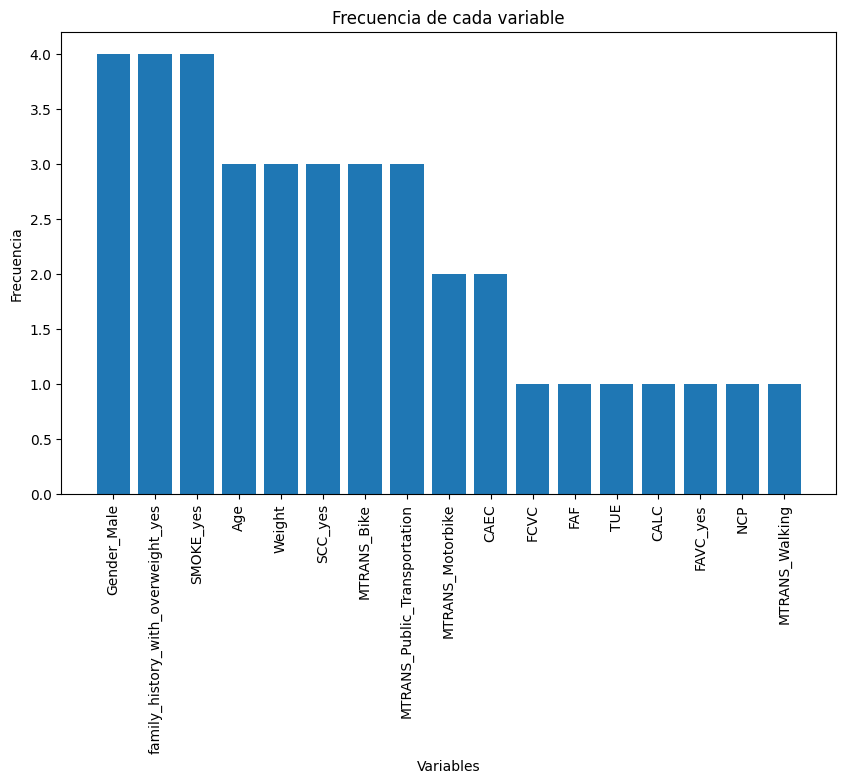

In [ ]:
#Imprimimos las frecuencias de las variables

import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.bar(list(contador_variables.keys()),contador_variables.values())
plt.xticks(rotation=90)
plt.xlabel('Variables')
plt.ylabel('Frecuencia')
plt.title('Frecuencia de cada variable')
plt.show()